# REINFORCE

In this notebook, we will implement REINFORCE algorithm for Discrete action spaces. The output of the network will be a probability distribution over actions.

I used some parts of the following code and the RL course at Aalto University:
https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
import gym

from ContinuousCartPole import ContinuousCartPoleEnv

%matplotlib inline

In [2]:
def discount_rewards(r, gamma):
    discounted_r = torch.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size(-1))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [14]:
class Policy(torch.nn.Module):
    def __init__(self, state_space, action_space, action_bound):
        super().__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.action_bound = action_bound
        self.hidden = 64
        self.fc1 = torch.nn.Linear(state_space, self.hidden)
        self.out_mean = torch.nn.Linear(self.hidden, self.action_space)
        self.out_sigma = torch.nn.Parameter(torch.tensor([1.0]))
        self.value = torch.nn.Linear(self.hidden, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        mu = self.action_bound[0] * F.tanh(self.out_mean(x))
        sigma = F.softplus(self.out_sigma)
        value = self.value(x)
        return mu, sigma, value

    
class Agent(object):
    def __init__(self, policy):
        self.train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.policy = policy.to(self.train_device)
        self.optimizer = torch.optim.RMSprop(policy.parameters(), lr=1e-3)
        self.gamma = 0.98
        self.states = []
        self.action_probs = []
        self.rewards = []
        self.state_values = []

    def episode_finished(self, episode_number):
        action_probs = torch.stack(self.action_probs, dim=0) \
                .to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        state_values = torch.stack(self.state_values, dim=0).to(self.train_device).squeeze(-1)
        self.states, self.action_probs, self.rewards, self.state_values = [], [], [], []

        G = discount_rewards(rewards, self.gamma)
        G = G.detach() # target should be fix and should not be affected by gradient. So we detach it

        advantage = G - state_values

        actor_loss = - (action_probs * advantage.detach()).mean() # the multiplier of log_prob is not part of gradient. So we detach it.
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, observation, evaluation=False):
        x = torch.from_numpy(observation).float().to(self.train_device)
        mu, sigma, value = self.policy(x)
        dist = Normal(mu, sigma)
        if evaluation:
            return mu
        action = dist.sample()
        act_log_prob = dist.log_prob(action)
        return action, act_log_prob, value

    def store_outcome(self, observation, action_prob, reward, state_value):
        self.states.append(observation)
        self.action_probs.append(action_prob)
        self.rewards.append(torch.Tensor([reward]))
        self.state_values.append(state_value)

# Train

In [15]:
# Create a Gym environment
train_episodes = 10000
env = ContinuousCartPoleEnv()

In [16]:
env.action_space.low, env.action_space.high

(array([-1.]), array([1.]))

In [17]:
env.observation_space.shape

(4,)

action_space_dim:  1
observation_space_dim:  4
Episode 0 finished. Total reward: 8 (8 timesteps)
Episode 1 finished. Total reward: 14 (14 timesteps)
Episode 2 finished. Total reward: 19 (19 timesteps)
Episode 3 finished. Total reward: 56 (56 timesteps)
Episode 4 finished. Total reward: 42 (42 timesteps)
Episode 5 finished. Total reward: 11 (11 timesteps)
Episode 6 finished. Total reward: 21 (21 timesteps)
Episode 7 finished. Total reward: 15 (15 timesteps)
Episode 8 finished. Total reward: 12 (12 timesteps)
Episode 9 finished. Total reward: 18 (18 timesteps)
Episode 10 finished. Total reward: 9 (9 timesteps)
Episode 11 finished. Total reward: 7 (7 timesteps)
Episode 12 finished. Total reward: 9 (9 timesteps)
Episode 13 finished. Total reward: 15 (15 timesteps)
Episode 14 finished. Total reward: 23 (23 timesteps)
Episode 15 finished. Total reward: 29 (29 timesteps)
Episode 16 finished. Total reward: 9 (9 timesteps)
Episode 17 finished. Total reward: 76 (76 timesteps)
Episode 18 finished

Episode 156 finished. Total reward: 13 (13 timesteps)
Episode 157 finished. Total reward: 14 (14 timesteps)
Episode 158 finished. Total reward: 26 (26 timesteps)
Episode 159 finished. Total reward: 40 (40 timesteps)
Episode 160 finished. Total reward: 30 (30 timesteps)
Episode 161 finished. Total reward: 61 (61 timesteps)
Episode 162 finished. Total reward: 26 (26 timesteps)
Episode 163 finished. Total reward: 42 (42 timesteps)
Episode 164 finished. Total reward: 25 (25 timesteps)
Episode 165 finished. Total reward: 16 (16 timesteps)
Episode 166 finished. Total reward: 24 (24 timesteps)
Episode 167 finished. Total reward: 26 (26 timesteps)
Episode 168 finished. Total reward: 42 (42 timesteps)
Episode 169 finished. Total reward: 18 (18 timesteps)
Episode 170 finished. Total reward: 25 (25 timesteps)
Episode 171 finished. Total reward: 13 (13 timesteps)
Episode 172 finished. Total reward: 9 (9 timesteps)
Episode 173 finished. Total reward: 13 (13 timesteps)
Episode 174 finished. Total re

Episode 308 finished. Total reward: 23 (23 timesteps)
Episode 309 finished. Total reward: 28 (28 timesteps)
Episode 310 finished. Total reward: 42 (42 timesteps)
Episode 311 finished. Total reward: 37 (37 timesteps)
Episode 312 finished. Total reward: 81 (81 timesteps)
Episode 313 finished. Total reward: 31 (31 timesteps)
Episode 314 finished. Total reward: 35 (35 timesteps)
Episode 315 finished. Total reward: 11 (11 timesteps)
Episode 316 finished. Total reward: 61 (61 timesteps)
Episode 317 finished. Total reward: 28 (28 timesteps)
Episode 318 finished. Total reward: 42 (42 timesteps)
Episode 319 finished. Total reward: 25 (25 timesteps)
Episode 320 finished. Total reward: 43 (43 timesteps)
Episode 321 finished. Total reward: 29 (29 timesteps)
Episode 322 finished. Total reward: 13 (13 timesteps)
Episode 323 finished. Total reward: 38 (38 timesteps)
Episode 324 finished. Total reward: 95 (95 timesteps)
Episode 325 finished. Total reward: 91 (91 timesteps)
Episode 326 finished. Total 

Episode 461 finished. Total reward: 62 (62 timesteps)
Episode 462 finished. Total reward: 49 (49 timesteps)
Episode 463 finished. Total reward: 60 (60 timesteps)
Episode 464 finished. Total reward: 83 (83 timesteps)
Episode 465 finished. Total reward: 42 (42 timesteps)
Episode 466 finished. Total reward: 46 (46 timesteps)
Episode 467 finished. Total reward: 30 (30 timesteps)
Episode 468 finished. Total reward: 101 (101 timesteps)
Episode 469 finished. Total reward: 14 (14 timesteps)
Episode 470 finished. Total reward: 78 (78 timesteps)
Episode 471 finished. Total reward: 58 (58 timesteps)
Episode 472 finished. Total reward: 72 (72 timesteps)
Episode 473 finished. Total reward: 21 (21 timesteps)
Episode 474 finished. Total reward: 23 (23 timesteps)
Episode 475 finished. Total reward: 44 (44 timesteps)
Episode 476 finished. Total reward: 42 (42 timesteps)
Episode 477 finished. Total reward: 25 (25 timesteps)
Episode 478 finished. Total reward: 40 (40 timesteps)
Episode 479 finished. Tota

Episode 615 finished. Total reward: 50 (50 timesteps)
Episode 616 finished. Total reward: 44 (44 timesteps)
Episode 617 finished. Total reward: 11 (11 timesteps)
Episode 618 finished. Total reward: 23 (23 timesteps)
Episode 619 finished. Total reward: 16 (16 timesteps)
Episode 620 finished. Total reward: 158 (158 timesteps)
Episode 621 finished. Total reward: 42 (42 timesteps)
Episode 622 finished. Total reward: 21 (21 timesteps)
Episode 623 finished. Total reward: 41 (41 timesteps)
Episode 624 finished. Total reward: 16 (16 timesteps)
Episode 625 finished. Total reward: 67 (67 timesteps)
Episode 626 finished. Total reward: 8 (8 timesteps)
Episode 627 finished. Total reward: 89 (89 timesteps)
Episode 628 finished. Total reward: 64 (64 timesteps)
Episode 629 finished. Total reward: 85 (85 timesteps)
Episode 630 finished. Total reward: 54 (54 timesteps)
Episode 631 finished. Total reward: 13 (13 timesteps)
Episode 632 finished. Total reward: 72 (72 timesteps)
Episode 633 finished. Total 

Episode 767 finished. Total reward: 56 (56 timesteps)
Episode 768 finished. Total reward: 57 (57 timesteps)
Episode 769 finished. Total reward: 61 (61 timesteps)
Episode 770 finished. Total reward: 51 (51 timesteps)
Episode 771 finished. Total reward: 30 (30 timesteps)
Episode 772 finished. Total reward: 62 (62 timesteps)
Episode 773 finished. Total reward: 34 (34 timesteps)
Episode 774 finished. Total reward: 37 (37 timesteps)
Episode 775 finished. Total reward: 24 (24 timesteps)
Episode 776 finished. Total reward: 62 (62 timesteps)
Episode 777 finished. Total reward: 61 (61 timesteps)
Episode 778 finished. Total reward: 39 (39 timesteps)
Episode 779 finished. Total reward: 108 (108 timesteps)
Episode 780 finished. Total reward: 71 (71 timesteps)
Episode 781 finished. Total reward: 14 (14 timesteps)
Episode 782 finished. Total reward: 28 (28 timesteps)
Episode 783 finished. Total reward: 44 (44 timesteps)
Episode 784 finished. Total reward: 23 (23 timesteps)
Episode 785 finished. Tota

Episode 922 finished. Total reward: 90 (90 timesteps)
Episode 923 finished. Total reward: 10 (10 timesteps)
Episode 924 finished. Total reward: 38 (38 timesteps)
Episode 925 finished. Total reward: 31 (31 timesteps)
Episode 926 finished. Total reward: 27 (27 timesteps)
Episode 927 finished. Total reward: 24 (24 timesteps)
Episode 928 finished. Total reward: 37 (37 timesteps)
Episode 929 finished. Total reward: 69 (69 timesteps)
Episode 930 finished. Total reward: 60 (60 timesteps)
Episode 931 finished. Total reward: 96 (96 timesteps)
Episode 932 finished. Total reward: 14 (14 timesteps)
Episode 933 finished. Total reward: 53 (53 timesteps)
Episode 934 finished. Total reward: 76 (76 timesteps)
Episode 935 finished. Total reward: 139 (139 timesteps)
Episode 936 finished. Total reward: 140 (140 timesteps)
Episode 937 finished. Total reward: 56 (56 timesteps)
Episode 938 finished. Total reward: 41 (41 timesteps)
Episode 939 finished. Total reward: 8 (8 timesteps)
Episode 940 finished. Tota

Episode 1072 finished. Total reward: 145 (145 timesteps)
Episode 1073 finished. Total reward: 86 (86 timesteps)
Episode 1074 finished. Total reward: 32 (32 timesteps)
Episode 1075 finished. Total reward: 73 (73 timesteps)
Episode 1076 finished. Total reward: 46 (46 timesteps)
Episode 1077 finished. Total reward: 79 (79 timesteps)
Episode 1078 finished. Total reward: 46 (46 timesteps)
Episode 1079 finished. Total reward: 11 (11 timesteps)
Episode 1080 finished. Total reward: 186 (186 timesteps)
Episode 1081 finished. Total reward: 47 (47 timesteps)
Episode 1082 finished. Total reward: 44 (44 timesteps)
Episode 1083 finished. Total reward: 40 (40 timesteps)
Episode 1084 finished. Total reward: 55 (55 timesteps)
Episode 1085 finished. Total reward: 29 (29 timesteps)
Episode 1086 finished. Total reward: 16 (16 timesteps)
Episode 1087 finished. Total reward: 12 (12 timesteps)
Episode 1088 finished. Total reward: 81 (81 timesteps)
Episode 1089 finished. Total reward: 187 (187 timesteps)
Epis

Episode 1220 finished. Total reward: 59 (59 timesteps)
Episode 1221 finished. Total reward: 106 (106 timesteps)
Episode 1222 finished. Total reward: 170 (170 timesteps)
Episode 1223 finished. Total reward: 98 (98 timesteps)
Episode 1224 finished. Total reward: 171 (171 timesteps)
Episode 1225 finished. Total reward: 141 (141 timesteps)
Episode 1226 finished. Total reward: 64 (64 timesteps)
Episode 1227 finished. Total reward: 86 (86 timesteps)
Episode 1228 finished. Total reward: 108 (108 timesteps)
Episode 1229 finished. Total reward: 69 (69 timesteps)
Episode 1230 finished. Total reward: 28 (28 timesteps)
Episode 1231 finished. Total reward: 122 (122 timesteps)
Episode 1232 finished. Total reward: 127 (127 timesteps)
Episode 1233 finished. Total reward: 107 (107 timesteps)
Episode 1234 finished. Total reward: 97 (97 timesteps)
Episode 1235 finished. Total reward: 100 (100 timesteps)
Episode 1236 finished. Total reward: 30 (30 timesteps)
Episode 1237 finished. Total reward: 172 (172 t

Episode 1368 finished. Total reward: 98 (98 timesteps)
Episode 1369 finished. Total reward: 124 (124 timesteps)
Episode 1370 finished. Total reward: 31 (31 timesteps)
Episode 1371 finished. Total reward: 98 (98 timesteps)
Episode 1372 finished. Total reward: 95 (95 timesteps)
Episode 1373 finished. Total reward: 117 (117 timesteps)
Episode 1374 finished. Total reward: 31 (31 timesteps)
Episode 1375 finished. Total reward: 193 (193 timesteps)
Episode 1376 finished. Total reward: 113 (113 timesteps)
Episode 1377 finished. Total reward: 43 (43 timesteps)
Episode 1378 finished. Total reward: 71 (71 timesteps)
Episode 1379 finished. Total reward: 45 (45 timesteps)
Episode 1380 finished. Total reward: 67 (67 timesteps)
Episode 1381 finished. Total reward: 108 (108 timesteps)
Episode 1382 finished. Total reward: 164 (164 timesteps)
Episode 1383 finished. Total reward: 11 (11 timesteps)
Episode 1384 finished. Total reward: 178 (178 timesteps)
Episode 1385 finished. Total reward: 42 (42 timeste

Episode 1515 finished. Total reward: 163 (163 timesteps)
Episode 1516 finished. Total reward: 111 (111 timesteps)
Episode 1517 finished. Total reward: 42 (42 timesteps)
Episode 1518 finished. Total reward: 262 (262 timesteps)
Episode 1519 finished. Total reward: 8 (8 timesteps)
Episode 1520 finished. Total reward: 25 (25 timesteps)
Episode 1521 finished. Total reward: 29 (29 timesteps)
Episode 1522 finished. Total reward: 46 (46 timesteps)
Episode 1523 finished. Total reward: 164 (164 timesteps)
Episode 1524 finished. Total reward: 123 (123 timesteps)
Episode 1525 finished. Total reward: 35 (35 timesteps)
Episode 1526 finished. Total reward: 38 (38 timesteps)
Episode 1527 finished. Total reward: 166 (166 timesteps)
Episode 1528 finished. Total reward: 141 (141 timesteps)
Episode 1529 finished. Total reward: 38 (38 timesteps)
Episode 1530 finished. Total reward: 31 (31 timesteps)
Episode 1531 finished. Total reward: 130 (130 timesteps)
Episode 1532 finished. Total reward: 401 (401 times

Episode 1661 finished. Total reward: 23 (23 timesteps)
Episode 1662 finished. Total reward: 116 (116 timesteps)
Episode 1663 finished. Total reward: 47 (47 timesteps)
Episode 1664 finished. Total reward: 243 (243 timesteps)
Episode 1665 finished. Total reward: 117 (117 timesteps)
Episode 1666 finished. Total reward: 201 (201 timesteps)
Episode 1667 finished. Total reward: 189 (189 timesteps)
Episode 1668 finished. Total reward: 140 (140 timesteps)
Episode 1669 finished. Total reward: 193 (193 timesteps)
Episode 1670 finished. Total reward: 153 (153 timesteps)
Episode 1671 finished. Total reward: 292 (292 timesteps)
Episode 1672 finished. Total reward: 196 (196 timesteps)
Episode 1673 finished. Total reward: 25 (25 timesteps)
Episode 1674 finished. Total reward: 206 (206 timesteps)
Episode 1675 finished. Total reward: 156 (156 timesteps)
Episode 1676 finished. Total reward: 197 (197 timesteps)
Episode 1677 finished. Total reward: 121 (121 timesteps)
Episode 1678 finished. Total reward: 

Episode 1807 finished. Total reward: 73 (73 timesteps)
Episode 1808 finished. Total reward: 69 (69 timesteps)
Episode 1809 finished. Total reward: 141 (141 timesteps)
Episode 1810 finished. Total reward: 251 (251 timesteps)
Episode 1811 finished. Total reward: 256 (256 timesteps)
Episode 1812 finished. Total reward: 204 (204 timesteps)
Episode 1813 finished. Total reward: 18 (18 timesteps)
Episode 1814 finished. Total reward: 136 (136 timesteps)
Episode 1815 finished. Total reward: 109 (109 timesteps)
Episode 1816 finished. Total reward: 47 (47 timesteps)
Episode 1817 finished. Total reward: 315 (315 timesteps)
Episode 1818 finished. Total reward: 91 (91 timesteps)
Episode 1819 finished. Total reward: 224 (224 timesteps)
Episode 1820 finished. Total reward: 106 (106 timesteps)
Episode 1821 finished. Total reward: 68 (68 timesteps)
Episode 1822 finished. Total reward: 464 (464 timesteps)
Episode 1823 finished. Total reward: 526 (526 timesteps)
Episode 1824 finished. Total reward: 95 (95

Episode 1953 finished. Total reward: 188 (188 timesteps)
Episode 1954 finished. Total reward: 242 (242 timesteps)
Episode 1955 finished. Total reward: 174 (174 timesteps)
Episode 1956 finished. Total reward: 83 (83 timesteps)
Episode 1957 finished. Total reward: 131 (131 timesteps)
Episode 1958 finished. Total reward: 352 (352 timesteps)
Episode 1959 finished. Total reward: 227 (227 timesteps)
Episode 1960 finished. Total reward: 395 (395 timesteps)
Episode 1961 finished. Total reward: 170 (170 timesteps)
Episode 1962 finished. Total reward: 387 (387 timesteps)
Episode 1963 finished. Total reward: 32 (32 timesteps)
Episode 1964 finished. Total reward: 56 (56 timesteps)
Episode 1965 finished. Total reward: 286 (286 timesteps)
Episode 1966 finished. Total reward: 39 (39 timesteps)
Episode 1967 finished. Total reward: 352 (352 timesteps)
Episode 1968 finished. Total reward: 226 (226 timesteps)
Episode 1969 finished. Total reward: 239 (239 timesteps)
Episode 1970 finished. Total reward: 40

Episode 2098 finished. Total reward: 120 (120 timesteps)
Episode 2099 finished. Total reward: 175 (175 timesteps)
Episode 2100 finished. Total reward: 44 (44 timesteps)
Episode 2101 finished. Total reward: 134 (134 timesteps)
Episode 2102 finished. Total reward: 152 (152 timesteps)
Episode 2103 finished. Total reward: 428 (428 timesteps)
Episode 2104 finished. Total reward: 90 (90 timesteps)
Episode 2105 finished. Total reward: 283 (283 timesteps)
Episode 2106 finished. Total reward: 258 (258 timesteps)
Episode 2107 finished. Total reward: 157 (157 timesteps)
Episode 2108 finished. Total reward: 95 (95 timesteps)
Episode 2109 finished. Total reward: 309 (309 timesteps)
Episode 2110 finished. Total reward: 368 (368 timesteps)
Episode 2111 finished. Total reward: 235 (235 timesteps)
Episode 2112 finished. Total reward: 35 (35 timesteps)
Episode 2113 finished. Total reward: 548 (548 timesteps)
Episode 2114 finished. Total reward: 192 (192 timesteps)
Episode 2115 finished. Total reward: 13

Episode 2243 finished. Total reward: 280 (280 timesteps)
Episode 2244 finished. Total reward: 136 (136 timesteps)
Episode 2245 finished. Total reward: 248 (248 timesteps)
Episode 2246 finished. Total reward: 112 (112 timesteps)
Episode 2247 finished. Total reward: 329 (329 timesteps)
Episode 2248 finished. Total reward: 256 (256 timesteps)
Episode 2249 finished. Total reward: 125 (125 timesteps)
Episode 2250 finished. Total reward: 305 (305 timesteps)
Episode 2251 finished. Total reward: 637 (637 timesteps)
Episode 2252 finished. Total reward: 162 (162 timesteps)
Episode 2253 finished. Total reward: 267 (267 timesteps)
Episode 2254 finished. Total reward: 119 (119 timesteps)
Episode 2255 finished. Total reward: 450 (450 timesteps)
Episode 2256 finished. Total reward: 107 (107 timesteps)
Episode 2257 finished. Total reward: 19 (19 timesteps)
Episode 2258 finished. Total reward: 58 (58 timesteps)
Episode 2259 finished. Total reward: 265 (265 timesteps)
Episode 2260 finished. Total reward

Episode 2388 finished. Total reward: 234 (234 timesteps)
Episode 2389 finished. Total reward: 86 (86 timesteps)
Episode 2390 finished. Total reward: 1.14e+03 (1135 timesteps)
Episode 2391 finished. Total reward: 190 (190 timesteps)
Episode 2392 finished. Total reward: 125 (125 timesteps)
Episode 2393 finished. Total reward: 204 (204 timesteps)
Episode 2394 finished. Total reward: 425 (425 timesteps)
Episode 2395 finished. Total reward: 120 (120 timesteps)
Episode 2396 finished. Total reward: 154 (154 timesteps)
Episode 2397 finished. Total reward: 137 (137 timesteps)
Episode 2398 finished. Total reward: 121 (121 timesteps)
Episode 2399 finished. Total reward: 195 (195 timesteps)
Episode 2400 finished. Total reward: 202 (202 timesteps)
Episode 2401 finished. Total reward: 486 (486 timesteps)
Episode 2402 finished. Total reward: 695 (695 timesteps)
Episode 2403 finished. Total reward: 809 (809 timesteps)
Episode 2404 finished. Total reward: 191 (191 timesteps)
Episode 2405 finished. Tota

Episode 2533 finished. Total reward: 196 (196 timesteps)
Episode 2534 finished. Total reward: 442 (442 timesteps)
Episode 2535 finished. Total reward: 305 (305 timesteps)
Episode 2536 finished. Total reward: 1.08e+03 (1081 timesteps)
Episode 2537 finished. Total reward: 705 (705 timesteps)
Episode 2538 finished. Total reward: 270 (270 timesteps)
Episode 2539 finished. Total reward: 186 (186 timesteps)
Episode 2540 finished. Total reward: 712 (712 timesteps)
Episode 2541 finished. Total reward: 262 (262 timesteps)
Episode 2542 finished. Total reward: 1e+03 (1002 timesteps)
Episode 2543 finished. Total reward: 669 (669 timesteps)
Episode 2544 finished. Total reward: 122 (122 timesteps)
Episode 2545 finished. Total reward: 26 (26 timesteps)
Episode 2546 finished. Total reward: 289 (289 timesteps)
Episode 2547 finished. Total reward: 261 (261 timesteps)
Episode 2548 finished. Total reward: 362 (362 timesteps)
Episode 2549 finished. Total reward: 267 (267 timesteps)
Episode 2550 finished. T

Episode 2677 finished. Total reward: 298 (298 timesteps)
Episode 2678 finished. Total reward: 129 (129 timesteps)
Episode 2679 finished. Total reward: 143 (143 timesteps)
Episode 2680 finished. Total reward: 237 (237 timesteps)
Episode 2681 finished. Total reward: 316 (316 timesteps)
Episode 2682 finished. Total reward: 215 (215 timesteps)
Episode 2683 finished. Total reward: 295 (295 timesteps)
Episode 2684 finished. Total reward: 1.59e+03 (1586 timesteps)
Episode 2685 finished. Total reward: 175 (175 timesteps)
Episode 2686 finished. Total reward: 231 (231 timesteps)
Episode 2687 finished. Total reward: 238 (238 timesteps)
Episode 2688 finished. Total reward: 3.2e+03 (3196 timesteps)
Episode 2689 finished. Total reward: 196 (196 timesteps)
Episode 2690 finished. Total reward: 247 (247 timesteps)
Episode 2691 finished. Total reward: 315 (315 timesteps)
Episode 2692 finished. Total reward: 250 (250 timesteps)
Episode 2693 finished. Total reward: 228 (228 timesteps)
Episode 2694 finishe

Episode 2820 finished. Total reward: 164 (164 timesteps)
Episode 2821 finished. Total reward: 215 (215 timesteps)
Episode 2822 finished. Total reward: 275 (275 timesteps)
Episode 2823 finished. Total reward: 990 (990 timesteps)
Episode 2824 finished. Total reward: 269 (269 timesteps)
Episode 2825 finished. Total reward: 174 (174 timesteps)
Episode 2826 finished. Total reward: 1.02e+03 (1020 timesteps)
Episode 2827 finished. Total reward: 421 (421 timesteps)
Episode 2828 finished. Total reward: 440 (440 timesteps)
Episode 2829 finished. Total reward: 133 (133 timesteps)
Episode 2830 finished. Total reward: 476 (476 timesteps)
Episode 2831 finished. Total reward: 565 (565 timesteps)
Episode 2832 finished. Total reward: 448 (448 timesteps)
Episode 2833 finished. Total reward: 315 (315 timesteps)
Episode 2834 finished. Total reward: 363 (363 timesteps)
Episode 2835 finished. Total reward: 779 (779 timesteps)
Episode 2836 finished. Total reward: 1.1e+03 (1096 timesteps)
Episode 2837 finishe

Episode 2962 finished. Total reward: 1.15e+03 (1150 timesteps)
Episode 2963 finished. Total reward: 486 (486 timesteps)
Episode 2964 finished. Total reward: 375 (375 timesteps)
Episode 2965 finished. Total reward: 403 (403 timesteps)
Episode 2966 finished. Total reward: 377 (377 timesteps)
Episode 2967 finished. Total reward: 544 (544 timesteps)
Episode 2968 finished. Total reward: 443 (443 timesteps)
Episode 2969 finished. Total reward: 384 (384 timesteps)
Episode 2970 finished. Total reward: 531 (531 timesteps)
Episode 2971 finished. Total reward: 334 (334 timesteps)
Episode 2972 finished. Total reward: 626 (626 timesteps)
Episode 2973 finished. Total reward: 464 (464 timesteps)
Episode 2974 finished. Total reward: 5.26e+03 (5264 timesteps)
Episode 2975 finished. Total reward: 380 (380 timesteps)
Episode 2976 finished. Total reward: 1.02e+03 (1017 timesteps)
Episode 2977 finished. Total reward: 620 (620 timesteps)
Episode 2978 finished. Total reward: 511 (511 timesteps)
Episode 2979 

Episode 3104 finished. Total reward: 147 (147 timesteps)
Episode 3105 finished. Total reward: 578 (578 timesteps)
Episode 3106 finished. Total reward: 2.48e+03 (2483 timesteps)
Episode 3107 finished. Total reward: 722 (722 timesteps)
Episode 3108 finished. Total reward: 314 (314 timesteps)
Episode 3109 finished. Total reward: 258 (258 timesteps)
Episode 3110 finished. Total reward: 430 (430 timesteps)
Episode 3111 finished. Total reward: 666 (666 timesteps)
Episode 3112 finished. Total reward: 331 (331 timesteps)
Episode 3113 finished. Total reward: 458 (458 timesteps)
Episode 3114 finished. Total reward: 433 (433 timesteps)
Episode 3115 finished. Total reward: 110 (110 timesteps)
Episode 3116 finished. Total reward: 1.21e+03 (1211 timesteps)
Episode 3117 finished. Total reward: 572 (572 timesteps)
Episode 3118 finished. Total reward: 638 (638 timesteps)
Episode 3119 finished. Total reward: 1.44e+03 (1436 timesteps)
Episode 3120 finished. Total reward: 1.08e+03 (1084 timesteps)
Episode

Episode 3243 finished. Total reward: 805 (805 timesteps)
Episode 3244 finished. Total reward: 1.87e+03 (1868 timesteps)
Episode 3245 finished. Total reward: 353 (353 timesteps)
Episode 3246 finished. Total reward: 787 (787 timesteps)
Episode 3247 finished. Total reward: 1.01e+03 (1008 timesteps)
Episode 3248 finished. Total reward: 452 (452 timesteps)
Episode 3249 finished. Total reward: 637 (637 timesteps)
Episode 3250 finished. Total reward: 550 (550 timesteps)
Episode 3251 finished. Total reward: 885 (885 timesteps)
Episode 3252 finished. Total reward: 1.53e+03 (1532 timesteps)
Episode 3253 finished. Total reward: 100 (100 timesteps)
Episode 3254 finished. Total reward: 3.72e+03 (3725 timesteps)
Episode 3255 finished. Total reward: 140 (140 timesteps)
Episode 3256 finished. Total reward: 2.08e+03 (2079 timesteps)
Episode 3257 finished. Total reward: 151 (151 timesteps)
Episode 3258 finished. Total reward: 290 (290 timesteps)
Episode 3259 finished. Total reward: 261 (261 timesteps)
E

Episode 3383 finished. Total reward: 168 (168 timesteps)
Episode 3384 finished. Total reward: 329 (329 timesteps)
Episode 3385 finished. Total reward: 289 (289 timesteps)
Episode 3386 finished. Total reward: 141 (141 timesteps)
Episode 3387 finished. Total reward: 293 (293 timesteps)
Episode 3388 finished. Total reward: 279 (279 timesteps)
Episode 3389 finished. Total reward: 150 (150 timesteps)
Episode 3390 finished. Total reward: 512 (512 timesteps)
Episode 3391 finished. Total reward: 637 (637 timesteps)
Episode 3392 finished. Total reward: 405 (405 timesteps)
Episode 3393 finished. Total reward: 411 (411 timesteps)
Episode 3394 finished. Total reward: 475 (475 timesteps)
Episode 3395 finished. Total reward: 274 (274 timesteps)
Episode 3396 finished. Total reward: 266 (266 timesteps)
Episode 3397 finished. Total reward: 965 (965 timesteps)
Episode 3398 finished. Total reward: 408 (408 timesteps)
Episode 3399 finished. Total reward: 298 (298 timesteps)
Episode 3400 finished. Total re

Episode 3522 finished. Total reward: 318 (318 timesteps)
Episode 3523 finished. Total reward: 453 (453 timesteps)
Episode 3524 finished. Total reward: 514 (514 timesteps)
Episode 3525 finished. Total reward: 1.2e+04 (12004 timesteps)
Episode 3526 finished. Total reward: 5.82e+03 (5819 timesteps)
Episode 3527 finished. Total reward: 9.67e+03 (9674 timesteps)
Episode 3528 finished. Total reward: 2.59e+03 (2592 timesteps)
Episode 3529 finished. Total reward: 810 (810 timesteps)
Episode 3530 finished. Total reward: 2.8e+03 (2795 timesteps)
Episode 3531 finished. Total reward: 3.82e+03 (3820 timesteps)
Episode 3532 finished. Total reward: 4.7e+03 (4696 timesteps)
Episode 3533 finished. Total reward: 2.02e+03 (2020 timesteps)
Episode 3534 finished. Total reward: 1.28e+03 (1277 timesteps)
Episode 3535 finished. Total reward: 146 (146 timesteps)
Episode 3536 finished. Total reward: 536 (536 timesteps)
Episode 3537 finished. Total reward: 1.66e+03 (1657 timesteps)
Episode 3538 finished. Total r

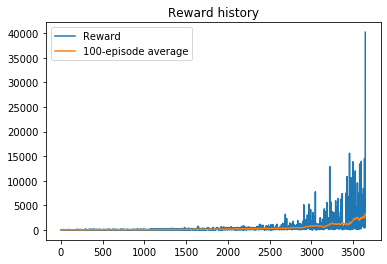

In [18]:

render = False

# Get dimensionalities of actions and observations
action_space_dim = env.action_space.shape[-1]
observation_space_dim = env.observation_space.shape[-1]
print('action_space_dim: ', action_space_dim)
print('observation_space_dim: ', observation_space_dim)

# Instantiate agent and its policy
policy = Policy(observation_space_dim, action_space_dim, env.action_space.high)
agent = Agent(policy)

# Arrays to keep track of rewards
reward_history, timestep_history = [], []
average_reward_history = []

# Run actual training
for episode_number in range(train_episodes):
    reward_sum, timesteps = 0, 0
    done = False
    # Reset the environment and observe the initial state
    observation = env.reset()

    # Loop until the episode is over
    while not done:
        # Get action from the agent
        action, action_probabilities, state_value = agent.get_action(observation)
        action = torch.clamp(action, env.action_space.low[0], env.action_space.high[0])
        previous_observation = observation

        # Perform the action on the environment, get new state and reward
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        # Store action's outcome (so that the agent can improve its policy)
        agent.store_outcome(previous_observation, action_probabilities, reward, state_value)

        if render:
            env.render()
            
        # Store total episode reward
        reward_sum += reward
        timesteps += 1


    print("Episode {} finished. Total reward: {:.3g} ({} timesteps)"
          .format(episode_number, reward_sum, timesteps))

    reward_history.append(reward_sum)
    timestep_history.append(timesteps)
    if episode_number > 100:
        avg = np.mean(reward_history[-100:])
    else:
        avg = np.mean(reward_history)
    average_reward_history.append(avg)

    agent.episode_finished(episode_number)
    
    if avg > 3000:
        print(f'Converged in episode {episode_number}')
        break

plt.plot(reward_history)
plt.plot(average_reward_history)
plt.legend(["Reward", "100-episode average"])
plt.title("Reward history")
plt.show()    

# Test

In [79]:
env = ContinuousCartPoleEnv()

[2019-11-10 07:49:27,137] Making new env: MountainCarContinuous-v0


In [80]:
render = True
episodes = 1
test_reward, test_len = 0, 0
for ep in range(episodes):
    done = False
    observation = env.reset()
    while not done:
        # Similar to the training loop above -
        # get the action, act on the environment, save total reward
        # (evaluation=True makes the agent always return what it thinks to be
        # the best action - there is no exploration at this point)
#         print(observation)
        action = agent.get_action(observation, evaluation=True)
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        if render:
            env.render()
        test_reward += reward
        test_len += 1
        if test_len > 1000:
            break
            
print("Average test reward:", test_reward/episodes, "episode length:", test_len/episodes)


Average test reward: 83.84366252350881 episode length: 203.0
